<a href="https://colab.research.google.com/github/MHoseinHoushmand/Clustering-documents-by-SFLA/blob/main/Clustering_by_SLFA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [21]:
import numpy as np
import pdb
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from numpy.linalg import norm
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
import matplotlib.pyplot as plt
import operator
import random



# Dataset prepration

In [2]:
def docs_as_tfidf(docs):
  vectorizer = TfidfVectorizer(
     max_df=0.5, #Removing terms that are used in more than 50% of articles
     min_df=5,   #Removing terms that are not used in less than 10 of articles
     stop_words="english",
     #  max_features=1000,
  )
  docs_vector = vectorizer.fit_transform(docs)
  print(len(docs_vector.toarray()[0]))
  return docs_vector.toarray()

In [4]:
def cosin_sim(a,b):
   return cosine_similarity([a], [b])[0][0]

In [14]:
categories = [  #Select 4 categories from fetch_20newsgroups dataset
    "alt.atheism",
    "comp.graphics",
    "sci.space",
    "rec.sport.hockey",
]
dataset = fetch_20newsgroups( #Preprocessing before using dataset
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories,
    shuffle=True,
    random_state=42,
)

labels = dataset.target[0:200]
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]
print(f"{len(dataset.data)} documents - {true_k} categories")

3758 documents - 4 categories




# Define Objects

In [5]:
class Cluster:
     def __init__(self):
         self.documents = []
         self.doc_mean = []

     def get_doc_mean(self):
        self.doc_mean = np.average(self.documents, axis=0)
        return self.doc_mean

     def SSE(self):     #Sum of squared error(SSE) as similarity of each documents with the cluster mean in document
         doc_mean = self.get_doc_mean()
         size = len(self.documents)
         sse=0
         for doc in self.documents:
             sse += cosin_sim(doc,doc_mean)**2
         try:
             sse = sse/size
         except ZeroDivisionError:
             return 0
         return sse


In [6]:
class Frog:
     def __init__(self,answer,docs_vector,n_clusters):
        self.answer = answer
        self.value = self.fitness(docs_vector,n_clusters)



     def build_clusters(self,docs_vector,n_clusters):#Build clusters for frog
          clusters = []
          for i in range(n_clusters):
             cluster = Cluster()
             clusters.append(cluster)
          for j in range(len(self.answer)):
             if -1 < self.answer[j]:
                clusters[self.answer[j]].documents.append(docs_vector[j])
          return clusters


     def WC(self,clusters):   #Calculate similarity within clusters
        WC = 0
        for cluster in clusters:
            WC += cluster.SSE()
        return WC


     def BC(self,doc_means):#Calculate similarity between clusters
          BC=0
          size = len(doc_means)
          for i in range(size):
              for j in range(i+1,size):
                  BC += cosin_sim(doc_means[i],doc_means[j])**2
          return BC


     def fitness(self,docs_vector,n_clusters):
           doc_means = []
          # pdb.set_trace()
           clusters = self.build_clusters(docs_vector,n_clusters)
           for i in range(n_clusters):
               doc_means.append(
                  clusters[i].get_doc_mean()
               )
           wc = self.WC(clusters) #Calculate similarity within clusters
           bc = self.BC(doc_means) #Calculate similarity between clusters
           fitness = wc/bc
           return fitness


     def cross_over(self,frog_b,docs_vector,n_clusters): #perform 2 points cross over
           frog_size = len(self.answer)
           points = sorted(np.random.choice(np.arange(0,frog_size), size=2, replace=False))
           answer1 = self.answer[:points[0]] + frog_b.answer[points[0]:points[1]] + self.answer[points[1]:]
           answer2 = frog_b.answer[:points[0]] + self.answer[points[0]:points[1]] + frog_b.answer[points[1]:]
           child1 = Frog(answer1,docs_vector,n_clusters)
           child2 = Frog(answer2,docs_vector,n_clusters)
           if child1.value > child2.value: # return best child
               return child1
           else :
               return child2

     def mutation(self,docs_vector,n_clusters):#Select len(answer)/4 of answers and change value
         new_ans = list(self.answer)
         size = int(len(self.answer)/4)
         indexes = np.random.choice(np.arange(0,len(self.answer)), size=size, replace=False)#Select indexes for changing
         values= [random.randint(0, n_clusters-1) for _ in range(size)]
         for i in range(size):
            new_ans[indexes[i]] = values[i]
         child = Frog(tuple(new_ans),docs_vector,n_clusters)
         return  child

In [7]:
class Memplex:
     def __init__(self):
         self.frogs = []

     def best(self):
        if len(self.frogs) > 0:
           return self.frogs[0]

     def worst(self,frogs):
        if len(self.frogs) > 0:
           return self.frogs[len(self.frogs)-1]

     def frogs_to_remove(self,sub_memplex):#Remove all frogs from submemplex in memplex
         for item in sub_memplex.frogs:
            self.frogs.remove(item)
         return self

     def add_frogs(self,submemplex):
         self.frogs = self.frogs + submemplex.frogs

In [8]:
class Submemplex:
     def __init__(self, memplex ,n_submemplex,memplex_size ):#Creating submemplex by Trigonometric probability
         self.frogs = []
         self.prob_list = []
         indexs = []
         for i in range(memplex_size):
             for j in range(2*(memplex_size-i)):
                 self.prob_list.append(i)
         k=0
         while(k!=n_submemplex):
            index = random.choice(self.prob_list)
            key = memplex.frogs[index].answer
           # pdb.set_trace()
            if index not in indexs:
                self.frogs.append(memplex.frogs[index])
                indexs.append(index)
                k+=1

     def best(self):
         local_best =  max(self.frogs, key=lambda frog: frog.value)
         return local_best

     def worst(self):
         local_worst =  min(self.frogs, key=lambda frog: frog.value)
         return local_worst


In [9]:
class Population:
     def __init__(self,n_clusters, n_population ,n_docs, docs_vector):
        answers = np.random.randint(0, n_clusters, size=(n_population , n_docs))
        self.frogs = []
        i=0
        for answer in answers:
           frog = Frog(tuple(answer),docs_vector,n_clusters)
           self.frogs.append(frog)
           print(i,frog.value)
           i+=1

     def clear_frogs(self):
        self.frogs.clear()

     def global_best(self,memplexes):#Return best frog of all memplexes
        local_bests = []
        for memplex in memplexes:
            local_best =  max(memplex.frogs, key=lambda frog: frog.value)
            local_bests.append(local_best)
        global_best =  max(local_bests, key=lambda frog: frog.value)
        return global_best

     def shufeling(self,memplexes):#Shufle memplexes and recreate population
         output = []
         for memplex in memplexes:
            output = output+ memplex.frogs
         self.frogs = output

In [16]:
class SFLA:
     def  __init__(self,n_clusters, max_iteration, dataset):
        self.n_clusters = n_clusters
        self.max_iteration =  max_iteration
        self.docs = dataset.data[0:200]
        self.n_population = 400 # Frogs number
        self.memplex_size = 20 #define as m
        self.n_memplex = 20 #define as n
        self.local_iteration = 10 #Iteration As local search
        self.n_submemplex = 5
        self.docs_vector = docs_as_tfidf(self.docs)  #Convert documents as tfidf values
        self.n_docs = len(self.docs)
        self.labels = dataset.target[0:200]


     def create_memplexes(self,population,n_memplex):#ّFrogs are distributed fairly in the memplexes
             population = sorted(population.frogs, key=lambda frog: frog.value)
             memplexes = []
             for i in range(n_memplex):
                 memplex = Memplex()
                 memplexes.append(memplex)
             for i in range(self.n_population):
                 memplexes[i % n_memplex].frogs.append(population[i])
             return memplexes

     def plot_frog(self, frog):
        lsa = TruncatedSVD(n_components=2)
        lsa_matrix = lsa.fit_transform(self.docs_vector)
        labels = frog.answer
        unique_labels, category_sizes = np.unique(labels, return_counts=True)
        true_k = unique_labels.shape[0]
        lsa = TruncatedSVD(n_components=2)
        plt.figure(figsize=(10, 8))
        plt.scatter(lsa_matrix[:, 0], lsa_matrix[:, 1], c=list(labels), cmap='viridis')

     def evaluation(self ,frog) :
          v = ()
          for i in frog.answer:
            v.append(0)
          homogeneity_score = metrics.homogeneity_score(self.labels, v)
          completeness_score = metrics.completeness_score(self.labels, v)
          v_measure_score = metrics.v_measure_score(self.labels, v)
          accuracy_score = metrics.accuracy_score(self.labels, v)
          print("homogeneity_score: " , homogeneity_score)
          print("completeness_score: ", completeness_score)
          print("v_measure_score: " , v_measure_score)
          print("accuracy_score: " , accuracy_score)



     def search(self):
        population = Population(self.n_clusters, self.n_population, self.n_docs, self.docs_vector)
        for i in range(self.max_iteration):
           memplexes = self.create_memplexes(population,self.n_memplex)
           population.clear_frogs()
           for j in range(self.n_memplex):
               submemplex = Submemplex(memplexes[j],self.n_submemplex,self.memplex_size)
               memplexes[j].frogs_to_remove(submemplex)
               print(i,j,len(memplexes[j].frogs))
               for k in range(self.local_iteration):
                    lfrog_best = submemplex.best()
                    lfrog_worst = submemplex.worst()
                    frog_out = lfrog_worst.cross_over(lfrog_best, self.docs_vector, self.n_clusters)
                    if (lfrog_worst.value < frog_out.value ):
                         submemplex.frogs.remove(lfrog_worst)
                         submemplex.frogs.append(frog_out)
                    else:
                         gfrog_best = population.global_best(memplexes)
                         frog_out = gfrog_best.cross_over(lfrog_worst, self.docs_vector, self.n_clusters)
                         if (lfrog_worst.value<frog_out.value):
                                      submemplex.frogs.remove(lfrog_worst)
                                      submemplex.frogs.append(frog_out)
                         else:
                                      frog_out = gfrog_best.mutation(self.docs_vector,self.n_clusters)
                                      submemplex.frogs.remove(lfrog_worst)
                                      submemplex.frogs.append(frog_out)
               memplexes[j].add_frogs(submemplex)
           gfrog_best = population.global_best(memplexes)
           print(gfrog_best.answer)
           print(gfrog_best.value)
           population.shufeling(memplexes)
        return gfrog_best

# Test code

In [18]:
sfla = SFLA(4,100,dataset)
best_frog = sfla.search()

379
0 0.0948378794884632
1 0.09782100652705447
2 0.09629787663404098
3 0.09380630597562291
4 0.09272551870929141
5 0.09681437448062055
6 0.10700397566668192
7 0.0920231260314278
8 0.08772741368717173
9 0.08185851336811044
10 0.09739029194014402
11 0.09414489615043353
12 0.10028516159968401
13 0.0911644900201381
14 0.08746187884988471
15 0.09241329674454463
16 0.0885793048096365
17 0.09837285801464345
18 0.09412615558684626
19 0.08667685112870857
20 0.09504469573360222
21 0.0921082436968252
22 0.09632754042862712
23 0.09071921871294746
24 0.09449948204917033
25 0.08945848143614041
26 0.10345240700328628
27 0.09618929617343198
28 0.09265324877833138
29 0.10051222925928527
30 0.09114961183659814
31 0.0936721936274912
32 0.10101038996316586
33 0.10226787843248121
34 0.09414147719811701
35 0.09703927147191986
36 0.09932910595551785
37 0.08825987803370247
38 0.09277662944707413
39 0.09532823682297605
40 0.08944714830927482
41 0.09980022466710771
42 0.09154621950529448
43 0.088828905646912
44

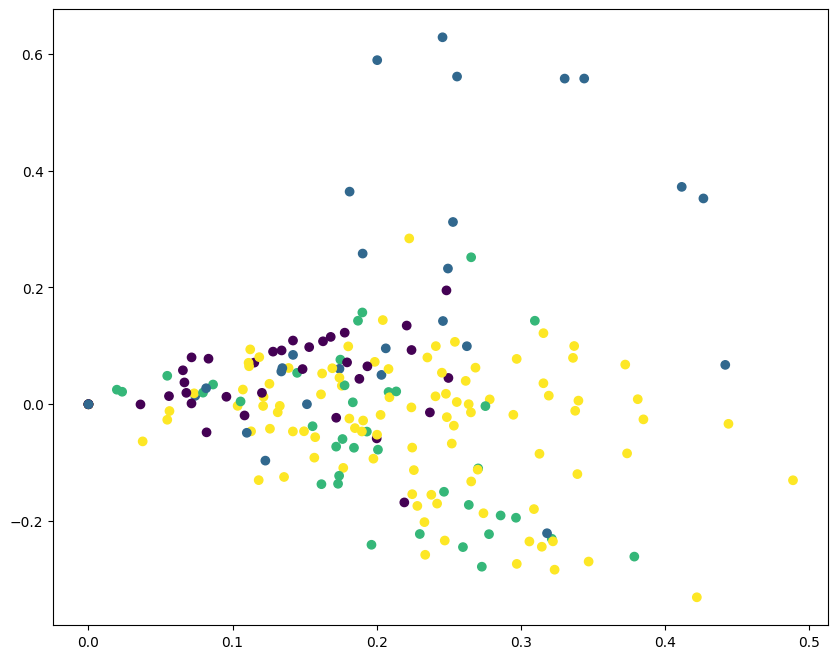

In [19]:
sfla.plot_frog(best_frog)

In [20]:
sfla.evaluation(best_frog)

AttributeError: ignored